# Real-Time System Simulation with EDF-VD Scheduling

This notebook showcases a simulation of a real-time system using the Earliest Deadline First with Virtual Deadlines (EDF-VD) scheduling approach. We develop classes for Tasks and Cores and introduce the `RealTimeSystem` class to facilitate task creation and allocation to cores.

In [ ]:
import numpy as np

## UUniFast Algorithm

The `UUniFast` algorithm is used here to distribute task utilizations summing up to a specified total utilization. It's a key tool for generating realistic task sets in real-time systems. Its code is implemented as follows:

In [ ]:
def uunifast(u, task_criticalities, rng, hc_redundancy):
    rep = {'high': hc_redundancy, 'low': 1}
    while True:
        utilizations = []
        sumU = u
        n = len(task_criticalities)
        for i in range(1, n):
            nextSumU = sumU * rng.random() ** (1.0 / (n - i))
            utilizations.append((sumU - nextSumU) / rep[task_criticalities[i - 1]])
            sumU = nextSumU
        utilizations.append(sumU / rep[task_criticalities[-1]])

        if all(ut <= 1 for ut in utilizations):
            return utilizations

## Task Class

The `Task` class models a task within the real-time system, including attributes like task ID, utilization, period, and criticality level. Its code is implemented as follows:

In [ ]:
class Task:
    def __init__(self, id, u, T, mu, criticality):
        self.id = id
        self.u = u
        self.T = T
        self.mu = mu
        self.criticality = criticality
        self.executed_time = 0
        self.deadline = T  # Initial deadline is the task period
        self.is_completed = False
        self.in_overrun_mode = False

    def switch_to_overrun_mode(self):
        self.in_overrun_mode = True

    def execute_timestep(self):
        if not self.is_completed:
            self.executed_time += 1
            if self.executed_time >= self.calculate_wcet():
                self.is_completed = True

    def calculate_wcet(self):
        if self.criticality == 'high' or not self.in_overrun_mode:
            # High-criticality tasks always use high WCET; low-criticality tasks use it in normal mode
            return int(self.T * self.u * self.mu)
        else:
            # Low-criticality tasks use normal WCET in overrun mode
            return int(self.T * self.u)

    def check_deadline(self, current_time):
        return current_time > self.deadline:

    def calculate_deadline(self, current_time):
        self.deadline = current_time + self.calculate_wcet()

    def __str__(self):
        return f"Task(id={self.id}, criticality={self.criticality}, deadline={self.deadline})"

## Core Class

The `Core` class represents a processing core in the real-time system, incorporating functionalities for task addition, task feasibility checks, and task scheduling using the EDF-VD algorithm. Its code is implemented as follows:

In [ ]:
class Core:
    def __init__(self, id, utilization):
        self.id = id
        self.utilization = utilization
        self._tasks = []
        self._hc_tasks = set()

    def add_task(self, task):
        self._tasks.append(task)
        if task.criticality == 'high':
            self._hc_tasks.add(task.id)

    def can_add_task(self, task, care_for_utilization=True):
        if self.remaining_utilization < task.u:
            return False
        elif care_for_utilization and ((1 - self.remaining_utilization) > self.utilization):
            return False
        elif (task.criticality == 'high') and (task.id in self._hc_tasks):
            return False
        else:
            return True

    @property
    def remaining_utilization(self):
        return 1 - sum(t.u for t in self._tasks)

    def __str__(self):
        return f'Core(id={self.id},utilization={self.utilization})'

## RealTimeSystem Class

The `RealTimeSystem` class orchestrates the simulation. It initializes cores, creates tasks, and implements task mapping strategies such as Worst-Fit Decreasing (WFD) and First-Fit Decreasing (FFD). The code of this class is implemented as follows


In [ ]:
class RealTimeSystem:

    def __init__(self, config):
        self._config = config
        self._tasks = []
        self._cores = []
        self._init_cores()

    def _init_cores(self):
        for i in range(self._config['n_cores']):
            self._cores.append(Core(f'core_{i}', self._config['per_core_utilization']))

    def _wfd_picker(self, task):
        cores_sorted = sorted(self._cores, key=lambda c: c.remaining_utilization, reverse=True)
        for core in cores_sorted:
            if core.can_add_task(task):
                return core
        raise Exception(f"Unable to schedule task {task.id}: insufficient capacity.")

    def _ffd_picker(self, task):
        for core in self._cores:
            if core.can_add_task(task):
                return core

        raise Exception(f"Unable to schedule task {task.id}: insufficient capacity.")

    def _get_mapping_strategy(self):
        strategy = self._config['task_mapping_strategy']
        if strategy == 'WFD':
            return self._wfd_picker
        elif strategy == 'FFD':
            return self._ffd_picker
        else:
            raise Exception('Illegal task mapping strategy')

    def _create_tasks(self):
        rng = np.random.default_rng(self._config['random_seed'])

        task_criticalities = rng.choice(
            ['high', 'low'],
            size=self._config['total_task_count'],
            p=[self._config['high_criticality_prob'], 1 - self._config['high_criticality_prob']]
        )

        task_utilizations = uunifast(
            self._config['per_core_utilization'] * self._config['n_cores'],
            task_criticalities,
            rng,
            self._calculate_hc_redundancy()
        )

        task_periods = rng.choice(self._config['period_sample_space'], size=self._config['total_task_count'])
        task_mus = ((rng.random((self._config['total_task_count'],)) + 1.5) / 5).tolist()

        for i in range(self._config['total_task_count']):
            self._tasks.append(Task(
                i,
                task_utilizations[i],
                task_periods[i],
                task_mus[i],
                task_criticalities[i]
            ))

    def _calculate_hc_redundancy(self):
        if self._config['core_failure_prob'] is None:
            return 1
        else:
            return int(np.ceil(
                np.log(self._config['fault_tolerance']) / np.log(self._config['core_failure_prob'])
            ))

    def _map_tasks_to_cores(self):
        hc_redundancy = self._calculate_hc_redundancy()
        sorted_tasks = sorted(self._tasks, key=lambda t: t.u, reverse=True)
        core_picker = self._get_mapping_strategy()
        for t in sorted_tasks:
            selected_core = core_picker(t)
            selected_core.add_task(t)

    def init_tasks(self):
        self._create_tasks()
        self._map_tasks_to_cores()
        self.task_mapping_report()

    def task_creation_report(self):
        rep = {'high': self._calculate_hc_redundancy(), 'low': 1}
        total_utilization = sum(t.u * rep[t.criticality] for t in self._tasks)
        print(f"Total Utilization: {total_utilization}")

    def task_mapping_report(self):
        print('Results:')
        for c in self._cores:
            print(str(c) + ':')
            print(f'Total core utilization: {sum(t.u for t in c._tasks)}')
            print('-' * 30)

## Simulation Configuration

We define the simulation configuration for our real-time system, including parameters like the number of cores, total task count, and other crucial settings.


In [ ]:
config = {
    'n_cores': 8,
    'random_seed': 33,
    'task_mapping_strategy': 'WFD', # ['WFD', 'FFD']
    'task_mapping_result_path': 'resources/allocation_results/sixteen_core_mapping',
    'core_failure_prob': 1e-4,
    'core_overrun_prob': 1e-1,
    'per_core_utilization': 0.85,
    'total_task_count': 200,
    'fault_tolerance': 1e-7,
    'high_criticality_prob': 0.5,
    'period_sample_space': [10, 20, 40, 50, 100, 200, 400, 500, 1000]
}

## Running the Simulation

We initialize the real-time system with the provided configuration, create tasks, and map them to cores. The task creation and mapping results are then displayed.


In [ ]:
rts = RealTimeSystem(config)
rts.init_tasks()

Results:
Core(id=core_0,utilization=0.85):
Total core utilization: 0.6245485663058565
------------------------------
Core(id=core_1,utilization=0.85):
Total core utilization: 0.6251668943708492
------------------------------
Core(id=core_2,utilization=0.85):
Total core utilization: 0.6250806592503082
------------------------------
Core(id=core_3,utilization=0.85):
Total core utilization: 0.6245846646961962
------------------------------
Core(id=core_4,utilization=0.85):
Total core utilization: 0.6245372931314056
------------------------------
Core(id=core_5,utilization=0.85):
Total core utilization: 0.625010171225037
------------------------------
Core(id=core_6,utilization=0.85):
Total core utilization: 0.6242947707210225
------------------------------
Core(id=core_7,utilization=0.85):
Total core utilization: 0.6249227243231056
------------------------------


# So far, only the first phase of the project has been shown.

Next, we will implement, test and visualize the EDF-VD scheduling algorithm. First of all, we introduce this algorithm as follows:

## Earliest Deadline First with Virtual Deadlines (EDF-VD) Scheduling

**Earliest Deadline First with Virtual Deadlines (EDF-VD)** is a specialized scheduling algorithm used in real-time systems, particularly effective in mixed-criticality systems where tasks have different levels of criticality.

This algorithm is designed to ensure the timely execution of high-criticality tasks while still providing a level of service to low-criticality tasks.

EDF-VD categorizes tasks based on their criticality levels, typically as 'high' or 'low'. In scenarios where high-criticality tasks exceed their expected execution times, the algorithm adjusts the scheduling to prioritize these tasks, often at the expense of lower-criticality tasks. The key to EDF-VD is managing these adjustments dynamically, ensuring system reliability and performance.


### Steps of the EDF-VD Algorithm

The EDF-VD scheduling algorithm involves several key steps:

1. **Initialization**: Prepare the necessary data structures for tracking tasks and their execution states.

2. **Task Selection**: Select the task with the earliest deadline for execution. High-criticality tasks are given priority in case of deadline ties.

3. **Execution**: Execute the selected task for a specified time unit.

4. **Deadline Adjustment**: For low-criticality tasks, virtual deadlines are used. These are typically shorter than actual deadlines to provide buffer time for high-criticality tasks.

5. **Criticality Switch**: If a high-criticality task exceeds its low-criticality WCET, the system switches to a high-criticality mode, altering the scheduling priorities.

6. **Completion and Deadline Monitoring**: Continuously monitor task completion and deadlines. Handle task completions and missed deadlines appropriately.


Now we rewrite and complete the functions of the `Core` class as follows:

In [ ]:
import random

class CompletedCore(Core):

    def __init__(self, id, utilization, core_failure_prob, core_overrun_prob):
        super().__init__(id, utilization)
        self.overrun_mode = False
        self.core_failure_prob = core_failure_prob
        self.core_overrun_prob = core_overrun_prob

    def check_core_failure(self):
        return random.random() < self.core_failure_prob

    def check_core_overrun(self):
        return random.random() < self.core_overrun_prob

    def select_task_to_execute(self, current_time):

        executable_tasks = [
            task for task in self._tasks if
            not task.is_completed
            and (not self.overrun_mode or task.criticality == 'high')
        ]

        for task in executable_tasks:
            if self.overrun_mode:
                task.switch_to_overrun_mode()

            task.calculate_deadline(current_time)

        executable_tasks.sort(key=lambda task: task.deadline)
        return executable_tasks[0] if executable_tasks else None

    def schedule(self, simulation_time):

        if len(self._tasks) == 0:
            raise Exception('No tasks given')

        self.execution_timeline = []
        self.deadline_misses = []

        current_time = 0
        while current_time < simulation_time:

            if self.check_core_failure():
                print(f"Core {self.id} failed at time {current_time}")
                break  # Stop scheduling if the core fails

            task = self.select_task_to_execute(current_time)

            if not self.overrun_mode and \
                task and \
                task.criticality == 'high' and \
                self.check_core_overrun():

                self.overrun_mode = True
                print(f"Core {self.id} overrun at time {current_time}")

            if not task:
                self.execution_timeline.append((current_time, None))
            else:
                task.execute_timestep()
                self.execution_timeline.append((current_time, task.id))

                if task.is_completed:
                    print(f"Task {task.id} completed at time {current_time}")

                if task.check_deadline(current_time):
                    self.deadline_misses.append((current_time, task.id))
                    print(f"Task {task.id} missed deadline at {current_time}")

            current_time += 1

        print(f"Core {self.id}: Schedule completed.")

## Testing the EDF-VD Scheduling Functions

In this test scenario, we will create a set of tasks with varying utilizations, periods, and criticalities. These tasks will be assigned to a single core, and we will run the EDF-VD scheduling algorithm over a defined simulation period. The objective is to observe:

- How tasks are prioritized and scheduled based on their deadlines.
- The handling of task completions.
- The detection of any deadline misses.

This test will help validate the correct functioning of our EDF-VD scheduling implementation in a controlled environment.

In [ ]:
# Create a set of sample tasks
tasks = [
    Task(id=1, u=0.1, T=50, mu=0.4, criticality='low'),
    Task(id=2, u=0.2, T=100, mu=0.5, criticality='high'),
    Task(id=3, u=0.15, T=80, mu=0.3, criticality='low'),
    Task(id=4, u=0.25, T=120, mu=0.35, criticality='high')
]

In [ ]:
# Create a core and add tasks to it
core = CompletedCore(id=1, utilization=0.85, core_failure_prob=1e-5, core_overrun_prob=0.2)
for task in tasks:
    core.add_task(task)

# Run the scheduling simulation for a defined time
simulation_time = 500  # Define the simulation period
core.schedule(simulation_time)

Task 1 completed at time 1
Task 3 completed at time 4
Core 1 overrun at time 9
Task 2 completed at time 14
Task 4 completed at time 24
Core 1: Schedule completed.


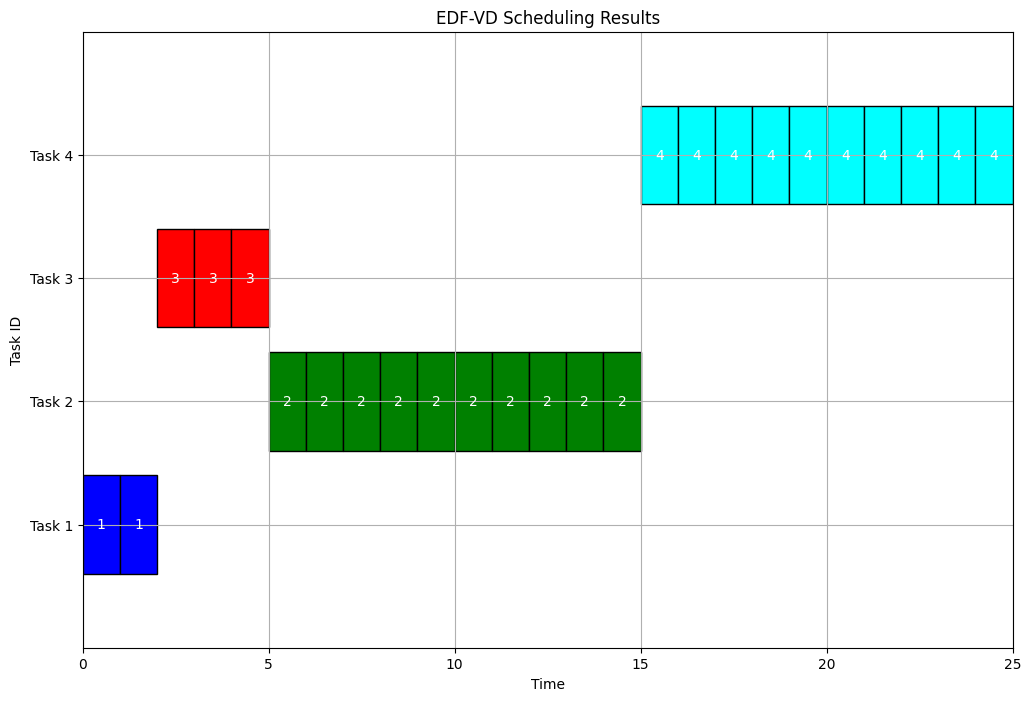

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_scheduling_results(core):
    fig, ax = plt.subplots(figsize=(12, 8))

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']
    task_colors = {task.id: colors[i % len(colors)] for i, task in enumerate(core._tasks)}

    try:
        map_ids = {k: i for i, k in enumerate(sorted(set([t.id for t in core._tasks])), start=1)}
    except:
      map_ids = {}

    wanted = set()

    for time, task_id in core.execution_timeline:
        if task_id is not None:
            wanted.add(task_id)
            rect = patches.Rectangle((time, map_ids[task_id]-0.4), 1, 0.8, edgecolor='black', facecolor=task_colors[task_id])
            ax.add_patch(rect)
            ax.text(time+0.5, map_ids[task_id], str(task_id), ha='center', va='center', color='white')

    for time, task_id in core.deadline_misses:
        ax.plot(time, task_id, 'rx')

    ax.set_xlabel('Time')
    ax.set_ylabel('Task ID')
    ax.set_title('EDF-VD Scheduling Results')
    ax.set_yticks([map_ids[id] for id in wanted])
    ax.set_yticklabels([f'Task {id}' for id in wanted])
    ax.set_xlim(0, max(filter(lambda x: x[1], core.execution_timeline), key=lambda x: x[0])[0] + 1)
    ax.set_ylim(0, len(core._tasks) + 1)
    ax.grid(True)
    plt.show()

plot_scheduling_results(core)

## Advanced Real-Time System Simulation with provided Scheduling

The simulation is extended through a subclass `NewRealTimeSystem`, which uses the `CompletedCore` class for a more sophisticated scheduling mechanism. The new class implemented as follows:

In [ ]:
class NewRealTimeSystem(RealTimeSystem):

    def _init_cores(self):
        # Using CompletedCore instead of Core class
        for i in range(self._config['n_cores']):
            self._cores.append(CompletedCore(f'core_{i}',
                    self._config['per_core_utilization'],
                       self._config['core_failure_prob'], self._config['core_overrun_prob']))

    def init_tasks(self):
        # initializing tasks without any report and logs
        self._create_tasks()
        self._map_tasks_to_cores()

In [ ]:
rts = NewRealTimeSystem(config)
rts.init_tasks()

for core in rts._cores:
    core.schedule(simulation_time=1000)

Task 10 completed at time 0
Task 44 completed at time 1
Task 187 completed at time 2
Task 79 completed at time 3
Core core_0 overrun at time 4
Task 56 completed at time 4
Task 80 completed at time 5
Task 130 completed at time 6
Task 0 completed at time 7
Task 116 completed at time 8
Task 92 completed at time 9
Task 85 completed at time 10
Task 179 completed at time 11
Task 78 completed at time 16
Task 72 completed at time 25
Task 14 completed at time 36
Core core_0: Schedule completed.
Task 119 completed at time 0
Task 161 completed at time 1
Task 34 completed at time 2
Task 59 completed at time 3
Task 33 completed at time 4
Task 175 completed at time 5
Task 75 completed at time 6
Task 58 completed at time 7
Task 13 completed at time 8
Task 107 completed at time 9
Task 153 completed at time 10
Task 185 completed at time 11
Task 98 completed at time 12
Task 30 completed at time 13
Task 83 completed at time 14
Task 67 completed at time 15
Task 52 completed at time 16
Task 138 completed a

### Plot the results for the first 3 cores of the system

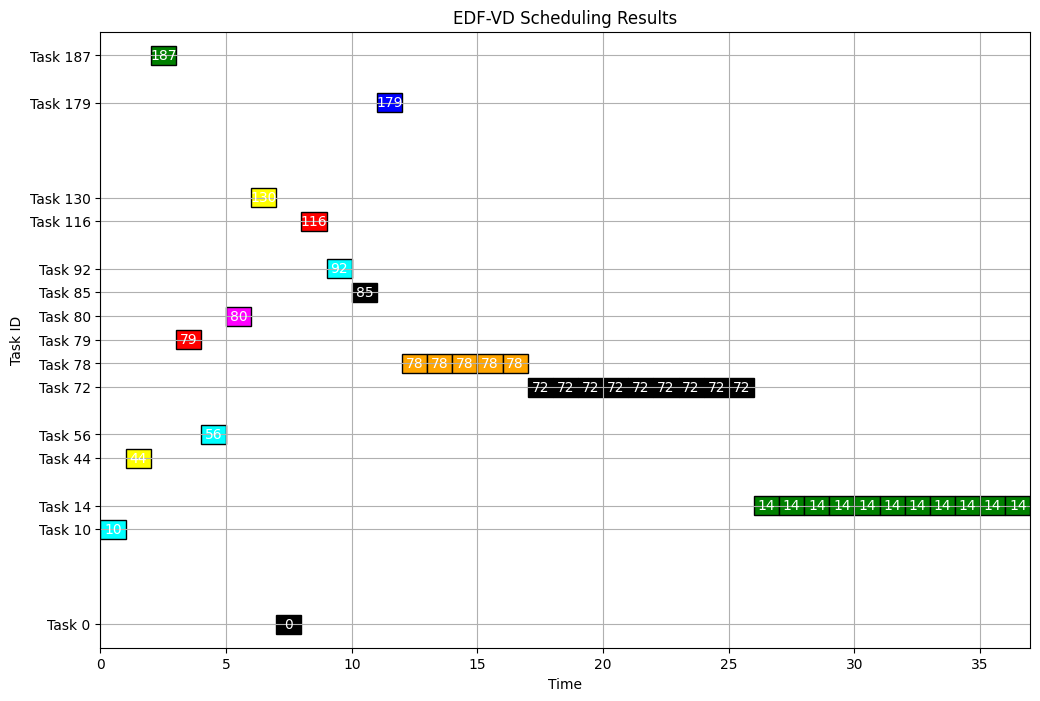

In [ ]:
plot_scheduling_results(rts._cores[0])

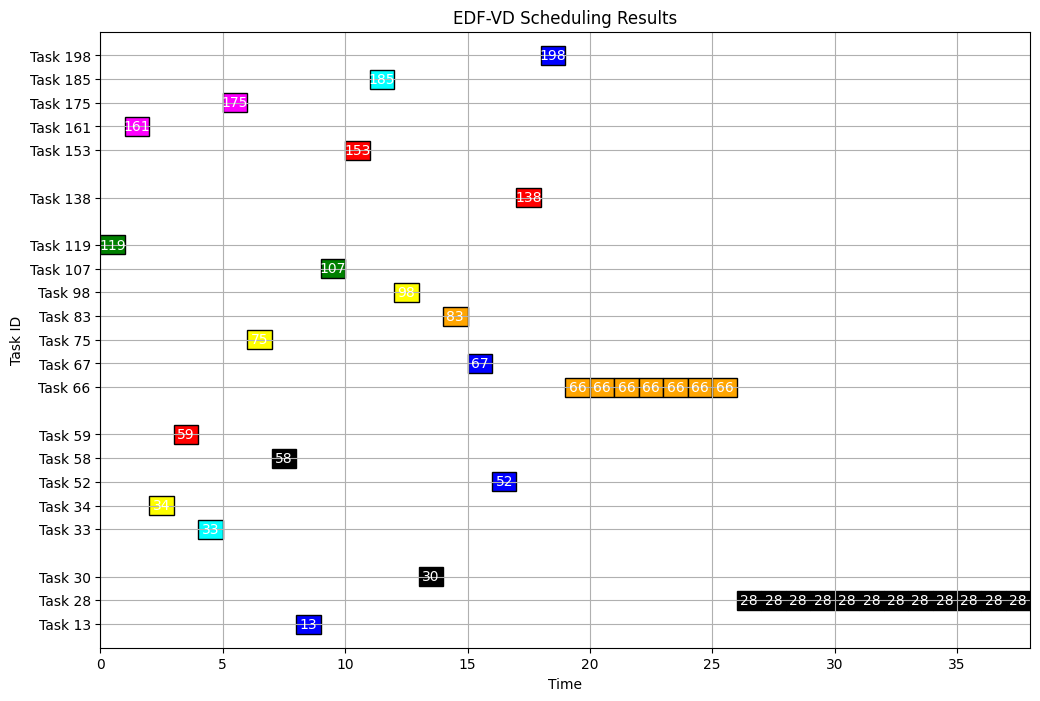

In [ ]:
plot_scheduling_results(rts._cores[1])

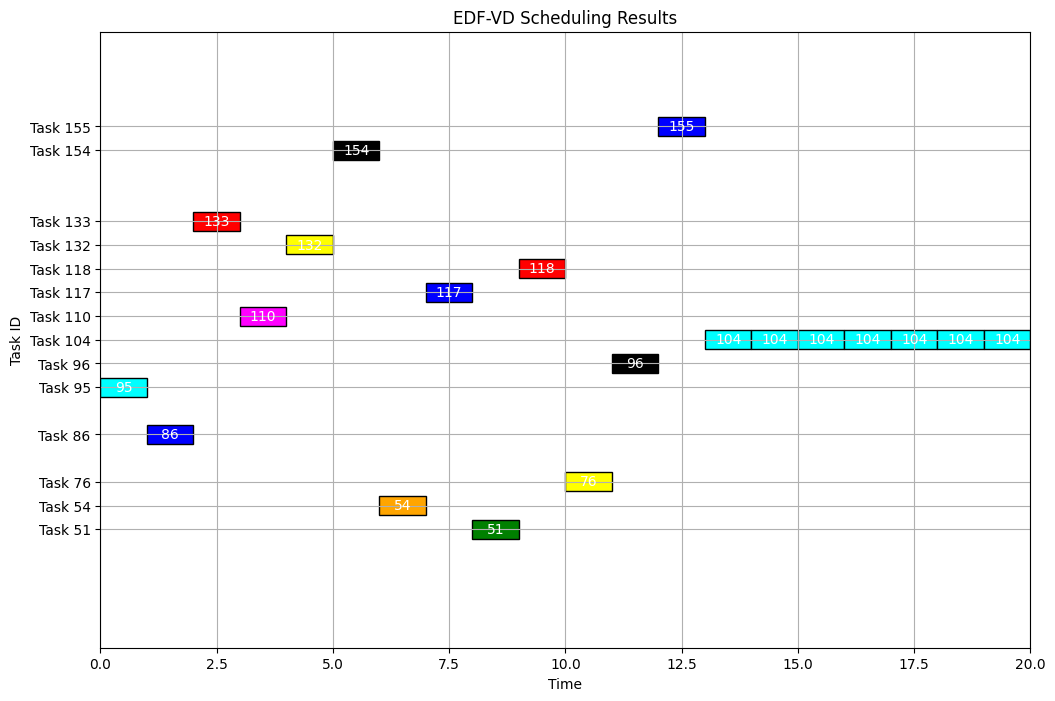

In [ ]:
plot_scheduling_results(rts._cores[2])